# Object Detection

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageColor
import time
from scipy.stats import norm

%matplotlib.inline
plt.stype.use('ggplot')

UsageError: Line magic function `%matplotlib.inline` not found.


## MobileNets
MobileNets, as the name suggests, are neural networks constructed for the purpose of running very efficiently (high FPS, low memory footprint) on mobile and embedded devices. MobileNets achieve this with 3 techniques:
 1. Perform a depthwise convolution followed by a 1x1 convolution rather than a standard conbolution. The 1x1 convolution is called a pointwise convolution if it's following a depthwise convolution. The combination of a depthwise convolution followed by a point wize convolution is sometimes called a separable depthwise convolution.
 2. Use a "width multiplier" - reduces the size of the input/output channels, set to a value between 0 and 1.
 3. Use a "resolution multiplier" - reduces the size of the original input, set to a value between 0 and 1.
 
These 3 techniques reduce the size of commulative parameters and therefore the computation required. Off course, generally models with more parameters achieve a higher accuracy. MobileNets are not silver bullet, while they perform very well larger models will outperform them. MobileNets are designed for mobile devices, NOT cloud GPU. The reason we're using them in this lab is automotive hardware is closer to mobile or embedded devices than beefy cloud GPUs.

### Convolutions
#### Vanilla Convolution
Before we get into the MobileNet convolution block let's take a step back and recall the computational cost of a vanilla convolution. There are N kernels of size Dk\*Dk. Each of these kernels goes over the entire input which is a Df\*Df\*M sized feature map or tensor (if that makes more sense). The computational cost is:

    Dg * Dg * M * N * Dk * Dk
    
Let Dg\*Dg be the size of the output feature map. Then a standard convolution takes in a Df\*Df\*M input feature map and returns a Dg\*Dg\*N feature map as output.
(Note: In the MobileNets paper, you may notice the above equation for computational cost uses Df instead of Dg. In the paper, they assume the output and input are the same spatial dimensions due to stride of 1 and padding, so doing so does not make a difference, but this would want Dg for different dimensions of input and output.

<img src=./images/standard_conv.png>


#### Depthwise Convolution
A depthwise convolution acts on each input channel separately with a different kernel. M input channels implies there are M Dk\*Dk kernels. Also notice this results in N being set to 1. If this doesn't make sense, think about the shape a kernel would have to be to act upon an individual channel. Computation cost:

    Dg * Dg * M * Dk * Dk
    
<img src=./images/depthwise_conv.png>

#### Pointwise Convolution
A pointwise convolution performs a 1x1 convolution, it's the same as a vanilla convolution except the kernel size is 1x1. Computation cost:

    Dk * Dk * Dg * Dg * M * N = 1 * 1 * Dg * Dg * M * N = Dg * Dg * M * N
<img src=./images/pointwise_conv.png>

Thus the total computation cost is for separable depthwise convolution:

    Dg * Dg * M * Dk * Dk + Dg * Dg * M * N
    
which results in 1/N + 1/(Dk)^2 reduction in computation.

MobileNets use a 3x3 kernel, so assuming a large enough N, separable depthwise convnets are ~9x more computationally efficient than vanilla convolutions!

### Width Multiplier
The 2nd technique for reducing the computational cost is the "width multiplier" which is a hyperparameter inhabiting the range \[0,1\] denoted here as α. α reduces the number of input and output channels proportionally:

    Df * Df * αM * Dk * Dk + Df * Df * αM * αN

### Resolution Multiplier
The 3rd technique for reducing the computaional cost is the "resolution multiplier" which is a hyperparameter inhabiting the range \[0,1\] denoted here as φ. φ reduces the size of the input feature map:

    φDf * φDf * M * Dk * Dk + φDf * φDf * M * N
   

Combining the width and resolution multipliers results in a computational cost of:

    φDf * φDf * αM * Dk * Dk + φDf * φDf * αM * N
    
Training MobileNets with different values of α and φ will result in different speed vs. accuracy tradeoffs. The folks at Google have run these experiments, the result are shown in the graphic below:

<img src=./images/mac-accuracy.png>

### Implement Separable Depthwise Convolution
I'll implement a separable depthwise convolution block and compare the number of parameters to a standard convolution block. I'll assume the width and resolution multipliers are set to 1.

In [4]:
def vanilla_conv_block(x, kernel_size, output_channels):
    x = tf.layers.conv2d(x, output_channels, kernel_size, (2,2), padding='SAME')
    x = tf.layers.batch_normalization(x)
    return tf.nn.relu(x)

def mobilenet_conv_block(x, kernel_size, output_channels):
    input_channel_dim = x.get_shape().as_list()[-1]
    W = tf.Variable(tf.truncated_normal((kernel_size, kernel_size, input_channel_dim, 1)))
    
    x = tf.nn.depthwise_conv2d(x, W, (1,2,2,1), padding='SAME')
    x = tf.layers.batch_normalization(x)
    x = tf.nn.relu(x)
    
    x = tf.layers.conv2d(x, output_channels, (1,1), padding='SAME')
    x = tf.layers.batch_normalization(x)
    return tf.nn.relu(x)

In [7]:
INPUT_CHANNELS = 32
OUTPUT_CHANNELS = 512
KERNEL_SIZE = 3
IMG_HEIGHT = 256
IMG_WIDTH = 256

with tf.Session(graph=tf.Graph()) as sess:
    x = tf.constant(np.random.randn(1, IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS), dtype=tf.float32)
    
    with tf.variable_scope('vanilla'):
        vanilla_conv = vanilla_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)
    with tf.variable_scope('mobile'):
        mobilenet = mobilenet_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)
        
    vanilla_parameters = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'vanilla')
    ]   
    mobile_parameters = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'mobile')
    ]
    
    print("VANILLA CONV BLOCK")
    total_vanilla_params = sum([p[1] for p in vanilla_parameters])
    for p in vanilla_parameters:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("Total number of params =", total_vanilla_params)
    print()

    print("MOBILENET CONV BLOCK")
    total_mobile_params = sum([p[1] for p in mobile_parameters])
    for p in mobile_parameters:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("Total number of params =", total_mobile_params)
    print()

    print("{0:.3f}x parameter reduction".format(total_vanilla_params /
                                             total_mobile_params))

VANILLA CONV BLOCK
Variable vanilla/conv2d/kernel:0: number of params = 147456
Variable vanilla/conv2d/bias:0: number of params = 512
Variable vanilla/batch_normalization/gamma:0: number of params = 512
Variable vanilla/batch_normalization/beta:0: number of params = 512
Total number of params = 148992

MOBILENET CONV BLOCK
Variable mobile/Variable:0: number of params = 288
Variable mobile/batch_normalization/gamma:0: number of params = 32
Variable mobile/batch_normalization/beta:0: number of params = 32
Variable mobile/conv2d/kernel:0: number of params = 16384
Variable mobile/conv2d/bias:0: number of params = 512
Variable mobile/batch_normalization_1/gamma:0: number of params = 512
Variable mobile/batch_normalization_1/beta:0: number of params = 512
Total number of params = 18272

8.154x parameter reduction


## MobileNet SSD
In this section you'll use a pretrained MobileNet SSD model to perform object detection. You can download the MobileNet SSD and other models from the TensorFlow detection model zoo. Paper describing comparing several object detection models.

### Single Shot Detection (SSD)
Many previous works in object detection involve more than one training phase. For example, the Faster-RCNN architecture first trains a Region Proposal Network(RPN) which decides which regions of the image are worth drawing a box around. RPN is then merged with a pretrained model for classification (classifies the regions). The image below is an RPN:

<img src=./images/faster-rcnn.png>

The SSD architecture is a single convolutional network which learns to predict bounding box locations and classify the locations in one pass. Put differently, SSD can be trained end to end while Faster-RCNN cannot. The SSD architecture consists of a base network followed by several convolutional layers:

<img src=./images/ssd_architecture.png>

NOTE: In this lab the base network is a MobileNet(instead of VGG16)

#### Detecting Boxes
SSD operates on feature maps to predict bounding box locations. Recall a feature map is of size Df \* Df \* M. For each feature map location k bounding boxes are predicted. Each bounding box carries with it the following information:
 - 4 corner bounding box offset locations (cx, cy, w, h)
 - C class probabilities (c1,c2, ..., cp)
 
SSD does not predict the shape of the box, rather just where the box is. The k bounding boxes each have a predetermined shape. This is illustrated in the figure below:

<img src=./images/ssd_feature_maps.png>

### SSD Feature Maps
Q1: Why does SSD use several differently sized feature maps to predict detections?  
A1: Differently sized feature maps allow for the network to learn to detect objects at different resolutions. This is illustrated in the figure with 8x8 and 4x4 feature maps. This may remind me of skip connections in fully convolutional networks.

Thr current approach leaves us with thousands of bounding box candidates, clearly the vast majority of them are nonsensical.

### Filtering Bounding Boxes
Q2: What are some ways which we can filter nonsensical bounding boxes?  
A2-1: Filters boxes based on IoU metric. For example, if a box has an IoU score less than 0.5 on all ground truth boxes it's removed.  
A2-2: Hard negative mining. This is a fancy way of saying "search for negatives examples the highest confidence". For example, a box that misclassifies a dog as a cat with 80% confidence. The authors of the SSD paper limit the positive to hard negative ratio to 3:1 at most. The actual positive to negative ratio is typically much higher and the number of boxes are typically reduced substantially.

#### Loss
With the final set of matched boxes we can compute the loss:

    L = 1/N * (Lclass + Lbox)

Where N is the total number of matched boxes, Lclass is a softmax loss for classification, and Lbox is a L1 smooth loss representing the error of the matched boxes with the ground truth boxes. L1 smooth loss is a modification of L1 loss which is more robust to outliers. In the event N is 0 the loss is set 0.

### SSD Summary
- Starts from a base model pretrained on ImageNet
- The base model is extended by several convolutional layers.
- Each feature map is used to predict bounding boxes. Diversity in feature map size allows object detection at defferent resolutions.
- Boxes are filtered by IoU metrics and hard negative mining.
- Loss is a combingation of classification(softmax) and detection(smooth L1)
- Model can be trained end to end

## Object Detection Inference
In this part of the lab I'll detect objects using pretrained object detection models. You can download the latest pretrained models from the model zoo, although do note that you may need a newer version of TensorFlow in order to use the newest models.

In [14]:
# Frozen inference graph files.
SSD_GRAPH_FILE = './models/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
RFCN_GRAPH_FILE = './models/rfcn_resnet101_coco_11_06_2017/frozen_inference_graph.pb'
FASTER_RCNN_GRAPH_FILE = './models/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb'

In [15]:
# Colors (one for each class)
cmap = ImageColor.colormap
COLOR_LIST = sorted([c for c in cmap.keys()])

In [16]:
# The information of ImageColor.colormap
#print("Number of colors = ", len(cmap))
#print()
#for color in cmap:
#    print(color)

In [19]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)

In [32]:
detection_graph = load_graph(SSD_GRAPH_FILE)
# detection_graph = load_graph(RFCN_GRAPH_FILE)
#detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)

image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

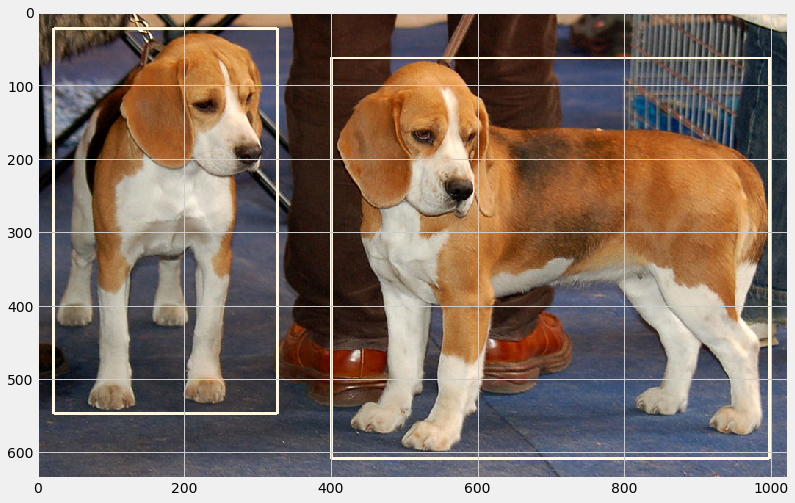

In [33]:
image = Image.open('./data/sample1.jpg')
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.8
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes)

    plt.figure(figsize=(12, 8))
    plt.imshow(image)

## Timing Detection
The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [34]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [35]:
with tf.Session(graph=detection_graph) as sess:
    times = time_detection(sess, 600, 1000, runs=10)

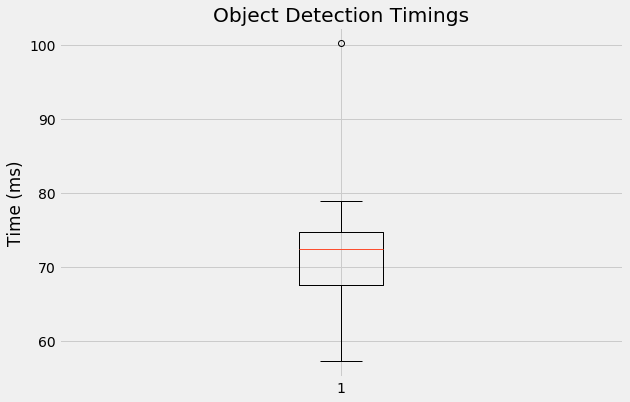

In [36]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)

## Detection on a Video

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('./data/driving.mp4'))

In [39]:
clip = VideoFileClip('./data/driving.mp4')

In [55]:
def pipeline(img):
    draw_img = Image.fromarray(img)
    
    boxes, scores, classes = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: np.expand_dims(img, 0)})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.8
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = draw_img.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(draw_img, box_coords, classes)
    
    return np.array(draw_img)

In [56]:
with tf.Session(graph=detection_graph) as sess:
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    new_clip = clip.fl_image(pipeline)
    
    new_clip.write_videofile('./result.mp4')


Moviepy - Building video ./result.mp4.
MoviePy - Writing audio in %s


MoviePy - Done.
Moviepy - Writing video ./result.mp4



Moviepy - Done !
Moviepy - video ready ./result.mp4


In [58]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('./result.mp4'))